In [7]:
# import necessary libraries 
import os 
from tkinter import Tcl
import matplotlib.pyplot as plt 
import numpy as np

from PIL import Image
from scipy import ndimage as nd
import json

from tqdm import tqdm 

import ipywidgets as widgets

In [8]:
def interactive_visualize(arr, cmap='gray', **kwargs):
    """
    This function creates an interactive visualization of the input array in 2D or 3D.

    Parameters:
    arr (ndarray): The input array to be visualized.
    cmap (str): The colormap to use for the plot. Default is 'viridis'
    **kwargs: Additional keyword arguments to be passed to plt.imshow.

    Returns:
    None
    """
    
    if arr.ndim == 2:
        plt.imshow(arr, cmap=cmap, **kwargs)
        plt.show()
    elif arr.ndim == 3:
    
        slider = widgets.IntSlider(
            min=0, max=arr.shape[0]-1, step=1, value=np.rint(arr.shape[0] / 2))

        def visualize_morph(slice_number):
            """
            This function plots the 3D visualization of the input array.

            Parameters:
            slice_number (int): The slice number of the input array to be visualized.

            Returns:
            None
            """
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
            plt.subplots_adjust(hspace=0.1, wspace=0.1)

            ax1.imshow(arr[slice_number, :, :], cmap=cmap, **kwargs)
            ax2.imshow(arr[:, slice_number, :], cmap=cmap, **kwargs)
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax3.imshow(arr[:, :, slice_number], cmap=cmap, **kwargs)
            ax3.set_xticks([])
            ax3.set_yticks([])
            plt.show()


        widgets.interact(visualize_morph, slice_number=slider)
    
    else:
        raise ValueError("Input array must be either 2D or 3D.")

In [9]:
# creating a list of fibrosis points including their value and coordinates 


In [10]:
# reading a file for example 
roi_path  = "E:\\Data\\sam_data\\new\\MD_1264_A9_Z0.0mm_Z3.3mm\\roi\\600-900x1350-1650x2350-2650"

In [11]:
tiffs = os.listdir(roi_path)
slices = Tcl().call('lsort', '-dict', tiffs)
vol = np.empty(shape=(300, 300, 300), dtype=np.uint8)
# Temporary list to hold blank slices
blank_slices = []

for i, fname in enumerate(slices):
    im = Image.open(os.path.join(roi_path, fname))
    imarray = np.array(im)
    
    if np.all(imarray == 0):
        blank_slices.append(imarray)
    else:
        vol[i - len(blank_slices), :, :] = imarray

# Append blank slices at the end
if len(blank_slices) > 0:
    vol[-len(blank_slices):] = blank_slices

In [12]:
th_vol = vol < 55
# th_vol = nd.binary_fill_holes(th_vol, np.ones((3,3,3)))
# th_vol = nd.binary_closing(th_vol, np.ones((3,3,3)))

In [13]:
interactive_visualize(vol)
interactive_visualize(th_vol)
th_vol = nd.binary_fill_holes(th_vol, np.ones((3,3,3)))
th_vol = nd.binary_closing(th_vol, np.ones((3,3,3)))
interactive_visualize(th_vol)

inth_vol = ~th_vol
interactive_visualize(inth_vol)

inth_vol = nd.binary_closing(inth_vol, np.ones((3,3,3)))
inth_vol = nd.binary_fill_holes(inth_vol, np.ones((3,3,3)))

interactive_visualize(inth_vol)


interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

In [14]:
dt3d = nd.distance_transform_edt(inth_vol)

In [15]:
msk = dt3d > 8

In [16]:
fib_vol = msk * dt3d

In [17]:
interactive_visualize(fib_vol, cmap='jet')

interactive(children=(IntSlider(value=150, description='slice_number', max=299), Output()), _dom_classes=('wid…

In [18]:
def sliding_window_max3d(volume, window_size, step_size):
    max_pixels = []
    depth, height, width = volume.shape
    fig, ax = plt.subplots()
    ax.imshow(volume[0], cmap='gray')
    for z in range(0, depth - window_size[0] + 1, step_size[0]):
        for y in range(0, height - window_size[1] + 1, step_size[1]):
            for x in range(0, width - window_size[2] + 1, step_size[2]):
                window = volume[z:z+window_size[0], y:y+window_size[1], x:x+window_size[2]]
                max_pixel = np.max(window)
                if max_pixel > 0:
                    max_pixel_pos = np.unravel_index(np.argmax(window), window.shape)
                    max_pixel_pos = (max_pixel_pos[2]+x, max_pixel_pos[1]+y, max_pixel_pos[0]+z)
                    max_pixels.append((max_pixel, max_pixel_pos))
                    rect = plt.Rectangle((x, z), window_size[2], window_size[0], fill=False, edgecolor='r', lw=1)
                    ax.add_patch(rect)
                    ax.plot(max_pixel_pos[0], max_pixel_pos[2], 'ro', markersize=2)
    plt.show()
    return max_pixels

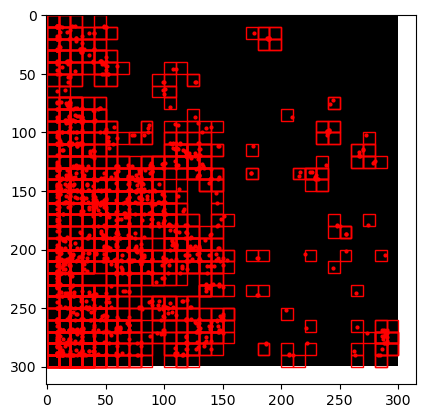

In [19]:
max_pixels3d = sliding_window_max3d(fib_vol, (10, 10, 10), (10, 10, 10))

In [20]:
max_pixels3d

[(8.54400374531753, (9, 48, 9)),
 (8.48528137423857, (10, 48, 9)),
 (9.0, (9, 58, 9)),
 (9.0, (10, 58, 9)),
 (9.0, (9, 60, 9)),
 (9.0, (10, 60, 9)),
 (8.366600265340756, (21, 67, 9)),
 (8.366600265340756, (9, 70, 9)),
 (8.12403840463596, (24, 70, 9)),
 (8.06225774829855, (49, 86, 9)),
 (9.0, (9, 39, 19)),
 (8.48528137423857, (10, 39, 18)),
 (9.0, (9, 41, 18)),
 (9.219544457292887, (10, 40, 19)),
 (8.94427190999916, (20, 47, 19)),
 (8.774964387392123, (9, 59, 10)),
 (9.273618495495704, (13, 59, 10)),
 (11.357816691600547, (25, 59, 19)),
 (9.0, (9, 60, 10)),
 (12.206555615733702, (17, 66, 14)),
 (12.36931687685298, (25, 62, 19)),
 (11.40175425099138, (30, 66, 18)),
 (8.602325267042627, (40, 69, 15)),
 (9.0, (9, 70, 10)),
 (10.816653826391969, (11, 70, 14)),
 (9.9498743710662, (20, 70, 13)),
 (9.433981132056603, (36, 70, 15)),
 (9.0, (40, 70, 15)),
 (8.12403840463596, (49, 87, 10)),
 (8.12403840463596, (50, 88, 10)),
 (8.06225774829855, (50, 90, 10)),
 (8.06225774829855, (177, 119, 15)),


In [40]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


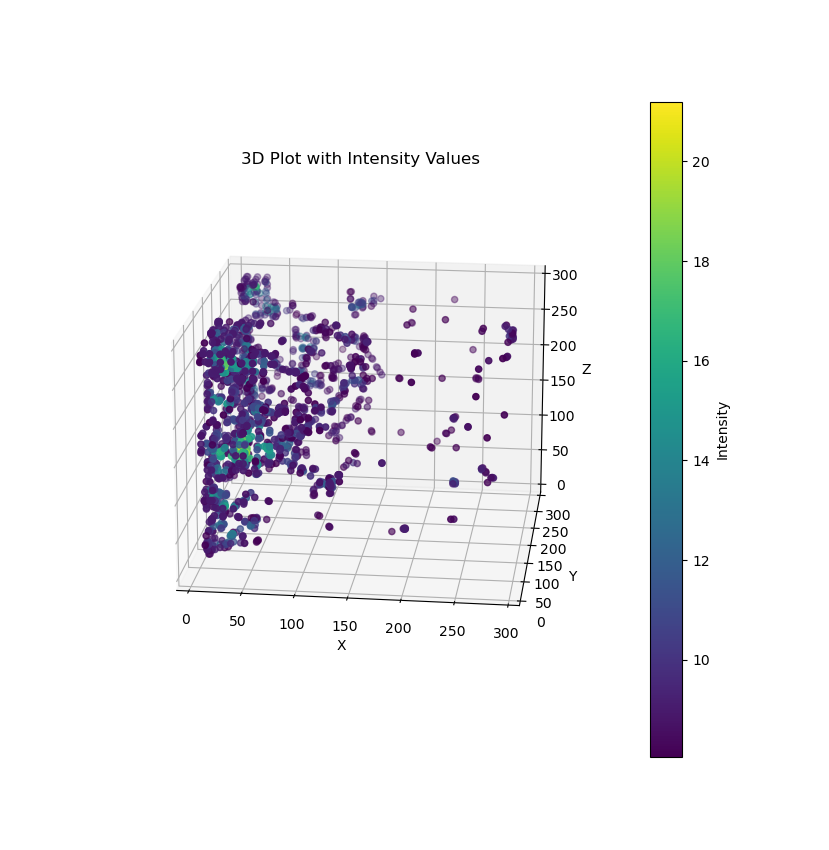

In [41]:
# Extract coordinates and intensity values
coordinates = np.array([point[1] for point in max_pixels3d])
intensity = np.array([point[0] for point in max_pixels3d])

# Create figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point with intensity as color
scatter = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=intensity, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot with Intensity Values')

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Intensity')

# Show the plot
plt.show()